In [4]:
import matplotlib.pyplot as plt
import torchdiffeq
import torch
import numpy as np
import os

In [10]:
dynamics = 'cubic'
save = False

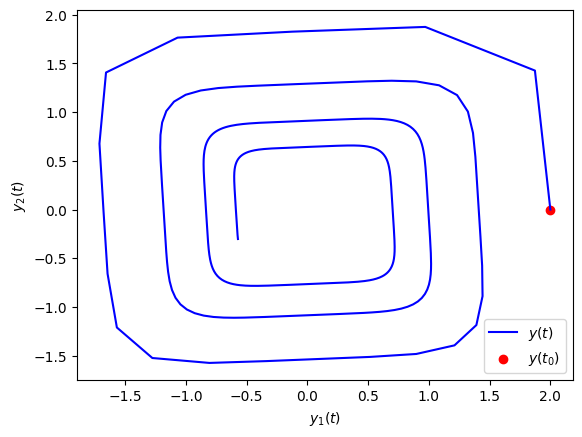

In [11]:
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., 1000)

class Lambda(torch.nn.Module):
    
    def forward(self, t, y):
        if dynamics == 'linear':
            return torch.mm(y, true_A)
        elif dynamics == 'cubic':
            return torch.mm(y**3, true_A)

true_y = torchdiffeq.odeint(Lambda(), true_y0, t, method='dopri5')

class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = torch.nn.Sequential(torch.nn.Linear(2,50), torch.nn.Tanh() , torch.nn.Linear(50,2))
        # self.net = torch.nn.Sequential(torch.nn.Linear(2,2))
        for m in self.net.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)
                torch.nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


def get_batch():
    batch_size_t = 20
    batch_size_y = 100
    s = torch.from_numpy(np.random.choice(np.arange(1000 - batch_size_t, dtype=np.int64), batch_size_y, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_size_t]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_size_t)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y



plt.plot(true_y.numpy()[:, :,0],true_y.numpy()[:,:,1], 'b-',label='$y(t)$')
plt.xlabel('$y_1(t)$')
plt.ylabel('$y_2(t)$')
plt.scatter(true_y0[0,0],true_y0[0,1], marker='o', color='r', label='$y(t_0)$')
plt.legend()
if save:
    plt.savefig(os.path.join(dynamics,'true_y.pdf'),format='pdf')

In [ ]:
device = torch.device('cuda:0')
METHODS = ['euler','midpoint','fixed_adams','rk4']
# METHODS = ['euler']
plt.figure(figsize=(15,10))
ii = 1
for method in METHODS:
    if save:
        if not os.path.exists(os.path.join(dynamics,method)):
            os.makedirs(os.path.join(dynamics,method))
    model = ODEFunc()
    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(),lr=1e-2)
    optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-2)
    # L = torch.nn.MSELoss()
    L = torch.nn.L1Loss()
    # L = lambda x,y: torch.mean(torch.abs(x-y))

    
    # plt.suptitle(method)
    loss_hist = []
    
    epochs = 200
    T_eval = 40
    for epoch in range(1,epochs+1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        batch_y0 = batch_y0.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)
        # batch_pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,method=method)
        batch_pred_y = torchdiffeq.odeint(model, batch_y0, batch_t, method=method)
        break
    
        loss = L(batch_pred_y, batch_y)
        loss.backward()
        optimizer.step()
        
        if epoch % T_eval == 0:
            plt.subplot(len(METHODS),epochs//T_eval, ii)
            plt.axis('off')
            ii += 1
            with torch.no_grad():
                pred_y = torchdiffeq.odeint(model, true_y0.to(device), t.to(device), method=method)
            plt.plot(true_y[:,:,0], true_y[:,:,1])
            plt.plot(pred_y[:,:,0].detach().cpu().numpy(), pred_y[:,:,1].detach().cpu().numpy())
            plt.title(str(epoch))
            
        loss_hist.append(loss.item())
        err = loss.item()
    if save:
    #     plt.savefig(os.path.join(dynamics,method,'adjoint_'+method+'.pdf'))
        torch.save(loss_hist,os.path.join(dynamics,method,'adjoint_'+method+'_loss.pth'))
    break
    # plt.figure(figsize=(10,4))
    # plt.semilogy(loss_hist)
    # if save:
    #     plt.savefig(os.path.join(dynamics,method,'ode_adjoint_loss_hist.pdf'),format='pdf')
if save:
    plt.savefig(os.path.join(dynamics,'adjoint.pdf'),format='pdf')

print(model.net[0].weight.data)

tensor([[ 4.6039e-03,  1.5292e-01],
        [ 1.2623e-01,  4.8031e-02],
        [-8.9465e-02,  1.0182e-01],
        [ 1.2964e-02, -4.0930e-02],
        [-2.6603e-01, -6.5413e-03],
        [ 7.6106e-02, -6.1805e-02],
        [-1.3041e-01,  1.1108e-01],
        [-1.5409e-04, -5.0276e-02],
        [ 3.2329e-02, -3.3255e-02],
        [ 2.0940e-04, -4.6334e-02],
        [-3.5320e-02,  4.4273e-03],
        [ 4.9067e-02, -2.7571e-02],
        [-2.8365e-02,  2.6497e-02],
        [ 1.6490e-01, -1.3889e-02],
        [-1.0089e-01, -9.6371e-02],
        [ 1.8296e-01,  1.2917e-01],
        [ 1.7808e-02, -3.2804e-02],
        [ 1.0650e-01,  1.1970e-01],
        [ 1.1205e-02,  3.6453e-02],
        [-8.4521e-02,  9.1443e-03],
        [-1.0688e-02,  6.8387e-03],
        [ 7.0837e-02, -2.9396e-02],
        [ 8.1810e-02, -1.2360e-01],
        [ 3.7565e-02,  8.4866e-02],
        [-4.6608e-02, -2.4191e-01],
        [-6.1942e-03,  3.6481e-02],
        [-5.8433e-02, -6.8671e-02],
        [ 4.1592e-02, -7.178

<Figure size 1500x1000 with 0 Axes>